<a href="https://colab.research.google.com/github/llawlaw23/Recommendation-System/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import gc
import re

In [ ]:
props1 = pd.read_csv("Datasets/item_properties_part1.1.csv")
props2 = pd.read_csv("Datasets/item_properties_part2.csv")
props = pd.concat([props1, props2])

### Data Understanding & Preprocessing

#### 1. Data Overview
- Brief description of the dataset ( size, number of features, number of columns and rows, and observations)
- Types of variables (numerical, categorical, datetime, etc.)
- Initial observations about the data (e.g., imbalance, missing data, outliers)

#### 2. Data Quality Checks
- Check for missing values and filling or dropping them.
- dropping columns.
- checking for outliers.

Mapping itemid to categoryid from Properties Dataset

In our dataset, the category of each item is stored within the properties table, specifically in rows where the property column has the value "categoryid". To extract a clean mapping of itemid → categoryid, we perform the following steps:

Filter the dataset to keep only rows where property == "categoryid".

Rename the value column to categoryid for clarity.

Convert the category IDs to integers to facilitate merging with other tables.


In [ ]:
props.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [ ]:
main = props[props["property"].isin(["categoryid", "available"])]

In [ ]:
main = main.pivot_table(
    index = "itemid",
    columns = "property",
    values = "value",
    aggfunc = "first"
    ).reset_index()

In [ ]:
rest = props[~props["property"].isin(["categoryid", "available"])].copy()

In [ ]:
df_items = rest.merge(main, on = "itemid", how = "left")

In [ ]:
df_items.head()

,timestamp,itemid,property,value,available,categoryid
0,1441508400000,206783,888,1116713 960601 n277.200,0,942
1,1439089200000,395014,400,n552.000 639502 n720.000 424566,0,1135
2,1431226800000,59481,790,n15360.000,1,498
3,1431831600000,156781,917,828513,0,891
4,1434250800000,89534,213,1121373,0,1577


In [ ]:
# clean the value column and keep values with n attached to them and add them if they are multiple
def sum_n_values(text):
    nums = re.findall(r"n([\d\.]+)", str(text))
    nums = [float(x) for x in nums]
    return sum(nums) if nums else None

df_items["value_n"] = df_items["value"].apply(sum_n_values)

In [ ]:
df_items = df_items.drop(columns = ["value"])

In [ ]:
df_items.head()

,timestamp,itemid,property,available,categoryid,value_n
0,1441508400000,206783,888,0,942,277.2
1,1439089200000,395014,400,0,1135,1272.0
2,1431226800000,59481,790,1,498,15360.0
3,1431831600000,156781,917,0,891,NaN
4,1434250800000,89534,213,0,1577,NaN


In [ ]:
df_items.shape

(17984049, 6)

In [ ]:
df_items = df_items.dropna()

In [ ]:
df_items.shape

(5174013, 6)

In [ ]:
df_items.head(10)

,timestamp,itemid,property,available,categoryid,value_n
0,1441508400000,206783,888,0,942,277.2
1,1439089200000,395014,400,0,1135,1272.0
2,1431226800000,59481,790,1,498,15360.0
7,1434250800000,98113,451,0,48,48.0
8,1439089200000,450113,888,0,227,504.0
9,1435460400000,244127,400,0,589,1272.0
12,1434250800000,169055,790,1,1298,21000.0
13,1435460400000,178601,790,0,1378,5400.0
15,1437274800000,49337,0,0,1613,36.0
17,1439694000000,48696,566,1,959,480.0


In [ ]:
cols_to_int = ["categoryid", "available", "property"]
df_items[cols_to_int] = df_items[cols_to_int].astype("Int64")

In [ ]:
itemid_value = df_items.groupby("itemid")["value_n"].count()

In [ ]:
Q1 = itemid_value.quantile(0.25)
Q3 = itemid_value.quantile(0.75)
IQR = Q3 - Q1

In [ ]:
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [ ]:
outlier_itemid_value = itemid_value[(itemid_value < lower_bound) | (itemid_value > upper_bound)].index

In [ ]:
is_outlier = df_items["itemid"].isin(outlier_itemid_value)

In [ ]:
df_items = df_items[~is_outlier]

In [ ]:
df_items.shape

(4361433, 6)

In [ ]:
print(df_items.columns[df_items.columns.duplicated()])

Index([], dtype='object')


In [ ]:
df_items["timestamp"] = pd.to_datetime(df_items["timestamp"], unit = "ms")

In [ ]:
# saved the clean csv as an new file in the cleaned folder and delete the previous one
df_items.to_csv("df_items.csv", index = False)
del df_items; gc.collect()

636

In [ ]:
events = pd.read_csv("Datasets/events.csv")
cats = pd.read_csv("Datasets/category_tree.csv")

In [ ]:
events["timestamp"] = pd.to_datetime(events["timestamp"], unit = "ms")

In [ ]:
events.shape

(2756101, 5)

In [ ]:
events.isnull().sum()

,0
timestamp,0
visitorid,0
event,0
itemid,0
transactionid,2733644


In [ ]:
events = events.drop(columns = ["transactionid"])

In [ ]:
events.head()

,timestamp,visitorid,event,itemid
0,2015-06-02 05:02:12.117,257597,view,355908
1,2015-06-02 05:50:14.164,992329,view,248676
2,2015-06-02 05:13:19.827,111016,view,318965
3,2015-06-02 05:12:35.914,483717,view,253185
4,2015-06-02 05:02:17.106,951259,view,367447


In [ ]:
# map view = 1 add to chart = 3 and purchase  = 5, replacing it in the old column. dataype to int
event_weights = {"view": 1, "addtocart": 2, "transaction": 3}
events["event"] = events["event"].map(event_weights)

In [ ]:
# change datatype of event to int
events["event"] = events["event"].fillna(0).astype(int)

In [ ]:
events.head(20)

,timestamp,visitorid,event,itemid
0,2015-06-02 05:02:12.117,257597,1,355908
1,2015-06-02 05:50:14.164,992329,1,248676
2,2015-06-02 05:13:19.827,111016,1,318965
3,2015-06-02 05:12:35.914,483717,1,253185
4,2015-06-02 05:02:17.106,951259,1,367447
5,2015-06-02 05:48:06.234,972639,1,22556
6,2015-06-02 05:12:03.240,810725,1,443030
7,2015-06-02 05:34:51.897,794181,1,439202
8,2015-06-02 04:54:59.221,824915,1,428805
9,2015-06-02 05:00:04.592,339335,1,82389


In [ ]:
# min in visitorid
events["visitorid"].min()

0

checking for outliers and clearing them

In [ ]:
visitor_event = events.groupby("visitorid")["event"].count()

In [ ]:
# print in descending order
visitor_event = visitor_event.sort_values(ascending = False)

In [ ]:
visitor_event.head(20)

,event
visitorid,
1150086,7757
530559,4328
152963,3024
895999,2474
163561,2410
371606,2345
286616,2252
684514,2246
892013,2024


In [ ]:
Q1 = visitor_event.quantile(0.25)
Q3 = visitor_event.quantile(0.75)
IQR = Q3 - Q1

In [ ]:
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [ ]:
upper_bound

np.float64(3.5)

In [ ]:
lower_bound

np.float64(-0.5)

In [ ]:
outlier_visitor_ids = visitor_event[(visitor_event < lower_bound) | (visitor_event > upper_bound)].index

In [ ]:
is_outlier = events["visitorid"].isin(outlier_visitor_ids)

In [ ]:
print (is_outlier)

0          False
1           True
2          False
3          False
4          False
           ...  
2756096    False
2756097    False
2756098    False
2756099    False
2756100    False
Name: visitorid, Length: 2756101, dtype: bool


In [ ]:
events_F = events[~is_outlier]

In [ ]:
events_F.head()

,timestamp,visitorid,event,itemid
0,2015-06-02 05:02:12.117,257597,1,355908
2,2015-06-02 05:13:19.827,111016,1,318965
3,2015-06-02 05:12:35.914,483717,1,253185
4,2015-06-02 05:02:17.106,951259,1,367447
5,2015-06-02 05:48:06.234,972639,1,22556


In [ ]:
events_F.shape

(1652380, 4)

In [ ]:
cats.isnull().sum()

,0
categoryid,0
parentid,25


In [ ]:
cats = cats.dropna()

In [ ]:
# saved the clean csv as an new file in the cleaned folder and delete the previous one
events_F.to_csv("events_cleaned.csv", index = False)
del events_F; gc.collect()

In [ ]:
# saved the clean csv as an new file in the cleaned folder and delete the previous one
cats.to_csv("cats_cleaned.csv", index = False)
del cats; gc.collect()

In [1]:
import pandas as pd

In [2]:
# Loading cleaned csv files
events_cleaned = pd.read_csv("cleaned/events_cleaned.csv")

cats_cleaned = pd.read_csv("cleaned/cats_cleaned.csv")

df_items = pd.read_csv("df_items.csv")

In [3]:
print(events_cleaned.shape)
print(cats_cleaned.shape)
print(df_items.shape)

(1652380, 4)
(1644, 2)
(4361433, 6)


In [25]:
df_items.head()

,timestamp,itemid,property,available,categoryid,value_n
0,2015-09-06 03:00:00,206783.0,888.0,0.0,942.0,277.2
1,2015-08-09 03:00:00,395014.0,400.0,0.0,1135.0,1272.0
2,2015-05-10 03:00:00,59481.0,790.0,1.0,498.0,15360.0
3,2015-06-14 03:00:00,98113.0,451.0,0.0,48.0,48.0
4,2015-08-09 03:00:00,450113.0,888.0,0.0,227.0,504.0


In [3]:
df_items = df_items[["timestamp","itemid","property","value_n","categoryid","available"]]

In [ ]:
tem_counts_groupby = events_cleaned.groupby("event").count()

In [33]:
tem_counts_groupby

,timestamp,visitorid,itemid
event,,,
1,1633682,1633682,1633682
3,16097,16097,16097
5,2601,2601,2601


neural network for your recommendation system

In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam

In [4]:
# Map users and items to integer indices
visitor_ids = events_cleaned["visitorid"].unique()
item_ids = df_items["itemid"].unique()

In [5]:
visitor_map = {v: i for i, v in enumerate(visitor_ids)}
item_map = {i: j for j, i in enumerate(item_ids)}

In [6]:
# Map to numeric indices
events_cleaned["visitor_idx"] = events_cleaned["visitorid"].map(visitor_map)
events_cleaned["item_idx"] = events_cleaned["itemid"].map(item_map)

In [7]:
# Drop rows with unknown user or item
events_cleaned = events_cleaned.dropna(subset = ["visitor_idx", "item_idx"])

In [8]:
# Convert to int
events_cleaned["visitor_idx"] = events_cleaned["visitor_idx"].astype(int)
events_cleaned["item_idx"] = events_cleaned["item_idx"].astype(int)

Final cleaning before neural network model

In [9]:
# Remove duplicate items
df_items_unique = df_items.drop_duplicates(subset = "itemid")

In [10]:
# Fill missing values
df_items_unique["categoryid"] = df_items_unique["categoryid"].fillna(-1).astype(int)
df_items_unique["available"] = df_items_unique["available"].fillna(0).astype(int)

C:\Users\Law\AppData\Local\Temp\ipykernel_19156\2669239481.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_items_unique["categoryid"] = df_items_unique["categoryid"].fillna(-1).astype(int)
C:\Users\Law\AppData\Local\Temp\ipykernel_19156\2669239481.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_items_unique["available"] = df_items_unique["available"].fillna(0).astype(int)


In [11]:
# Create item feature array aligned with item_map
item_feature_array = df_items_unique.set_index("itemid")[["categoryid", "available"]].reindex(item_ids).fillna(0).values

In [12]:
num_users = len(visitor_map)
num_items = len(item_map)
embedding_size = 32

In [13]:
# Map item features to each row
item_features_for_model = item_feature_array[events_cleaned["item_idx"].values]

In [14]:
# Use the event column directly as interaction target since i have map tthe items already
y = events_cleaned["event"].values.astype(np.float32)

TRAIN/TEST SPLIT

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X = events_cleaned[["visitor_idx", "item_idx"]].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42
)

Tuning and designing neutral network

In [17]:
num_users = len(visitor_map)
num_items = len(item_map)
embedding_size = 32

In [18]:
# user and item inputs
user_input = Input(shape = (1,), name = "user_input")
item_input = Input(shape = (1,), name = "item_input")

In [19]:
# Embeddings
user_embedding = Embedding(input_dim = num_users, output_dim = embedding_size, name = "user_embedding")(user_input)
item_embedding = Embedding(input_dim = num_items, output_dim = embedding_size, name = "item_embedding")(item_input)

In [20]:
# Flatten embeddings
user_vec = Flatten()(user_embedding)
item_vec = Flatten()(item_embedding)

In [21]:
# Adding item features
# from categoryid and available columns
df_items["categoryid"] = df_items["categoryid"].fillna(-1).astype(int)
df_items["available"] = df_items["available"].fillna(0).astype(int)

In [23]:
# Concatenate embeddings
concat = Concatenate()([user_vec, item_vec])

In [24]:
# Hidden layers
x = Dense(128, activation="relu")(concat)
x = Dense(64, activation="relu")(x)
output = Dense(1, activation="linear")(x)

# Output layer: predict interaction score
output = Dense(1, activation="linear")(x)

In [ ]:
# Build and compile model
model = Model(inputs = [user_input, item_input], outputs = output)
model.compile(optimizer = Adam(learning_rate = 0.001), loss = "mse", metrics = ["mae"])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 item_input (InputLayer)     [(None, 1)]                  0         []                            


                                                                                                  
 user_embedding (Embedding)  (None, 1, 32)                4118924   ['user_input[0][0]']          
                                                          8                                       
                                                                                                  
 item_embedding (Embedding)  (None, 1, 32)                1288044   ['item_input[0][0]']          
                                                          8                                       
                                                                                                  
 flatten (Flatten)           (None, 32)                   0         ['user_embedding[0][0]']      
                                                                                                  
 flatten_1 (Flatten)         (None, 32)                   0         ['item_embedding[0][0]']      
          

TRAIN MODEL

In [27]:
history = model.fit(
    [X_train[:, 0], X_train[:, 1]],
    y_train,
    validation_data = ([X_test[:, 0], X_test[:, 1]], y_test),
    epochs = 6,
    batch_size = 256
)

Epoch 1/10
4223/4223 [==============================] - 3784s 896ms/step - loss: 0.0732 - mae: 0.0644 - val_loss: 0.0689 - val_mae: 0.0659
Epoch 2/10
4223/4223 [==============================] - 2235s 529ms/step - loss: 0.0605 - mae: 0.0644 - val_loss: 0.0689 - val_mae: 0.0554
Epoch 3/10
4223/4223 [==============================] - 2091s 495ms/step - loss: 0.0484 - mae: 0.0563 - val_loss: 0.0718 - val_mae: 0.0636
Epoch 4/10
4223/4223 [==============================] - 2705s 641ms/step - loss: 0.0407 - mae: 0.0454 - val_loss: 0.0773 - val_mae: 0.0530
Epoch 5/10
4223/4223 [==============================] - 2071s 490ms/step - loss: 0.0368 - mae: 0.0400 - val_loss: 0.0764 - val_mae: 0.0562
Epoch 6/10
4223/4223 [==============================] - 2002s 474ms/step - loss: 0.0340 - mae: 0.0374 - val_loss: 0.0786 - val_mae: 0.0513
Epoch 7/10
4223/4223 [==============================] - 2221s 526ms/step - loss: 0.0320 - mae: 0.0348 - val_loss: 0.0805 - val_mae: 0.0577
Epoch 8/10
4223/4223 [=====

In [ ]:
results = model.evaluate(X_test, y_test, verbose = 0)

In [ ]:
test_loss = results[0]
test_accuracy = results[1]

In [ ]:
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
print(f"Final Training Accuracy: {train_accuracy:.4f}")
print(f"Final Training Loss: {train_loss:.4f}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")

TEST MODEL

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from collections import defaultdict

In [37]:
# Regression metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")

MSE: 0.0807, MAE: 0.0487


In [38]:
def precision_at_k(y_true, y_pred, k=10):
    top_k_idx = np.argsort(-y_pred)[:k]
    relevant = y_true[top_k_idx]
    return np.sum(relevant) / k

In [39]:
def recall_at_k(y_true, y_pred, k=10):
    top_k_idx = np.argsort(-y_pred)[:k]
    relevant = y_true[top_k_idx]
    return np.sum(relevant) / np.sum(y_true) if np.sum(y_true) > 0 else 0

In [40]:
y_pred = model.predict([X_test[:, 0], X_test[:, 1]])

8445/8445 [==============================] - 56s 7ms/step


In [41]:
user_scores = defaultdict(list)
user_labels = defaultdict(list)

for i in range(len(X_test)):
    user = X_test[i, 0]
    user_scores[user].append(y_pred[i])
    user_labels[user].append(y_test[i])

In [44]:
k = 10
precision_list = []
recall_list = []

for user in user_scores:
    scores = np.array(user_scores[user]).flatten()
    labels = np.array(user_labels[user])
    precision_list.append(precision_at_k(labels, scores, k))
    recall_list.append(recall_at_k(labels, scores, k))

print(f"Precision@{k}: {np.mean(precision_list):.4f}")
print(f"Recall@{k}: {np.mean(recall_list):.4f}")

Precision@10: 0.1084
Recall@10: 1.0000


In [32]:
# classification accuracy
y_pred_class = np.clip(np.rint(y_pred), 1, 3)
acc = accuracy_score(y_test, y_pred_class)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.9783


### Data Visualization and Analysing Business Question

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

Q1
- How many unique visitors in a month?

In [46]:
events_cleaned["timestamp"] = pd.to_datetime(events_cleaned["timestamp"])

In [ ]:
events_cleaned.head()

,timestamp,visitorid,event,itemid
0,2015-06-02 05:02:12.117,257597,1,355908
1,2015-06-02 05:13:19.827,111016,1,318965
2,2015-06-02 05:12:35.914,483717,1,253185
3,2015-06-02 05:02:17.106,951259,1,367447
4,2015-06-02 05:48:06.234,972639,1,22556


In [47]:
events_cleaned["year_month"] = events_cleaned["timestamp"].dt.to_period("M")

In [48]:
monthly_visitors = events_cleaned.groupby("year_month")["visitorid"].nunique().reset_index()

In [ ]:

print(monthly_visitors.head(10))

  year_month  visitorid
0    2015-05     274302
1    2015-06     276649
2    2015-07     337179
3    2015-08     279387
4    2015-09     155952


In [49]:
monthly_visitors["year_month"] = monthly_visitors["year_month"].astype(str)

In [54]:
color_map = {
    "2015-05": "#F5FAE1",
    "2015-06": "#EEE6CA",
    "2015-07": "#E5BEB5",
    "2015-08": "#896C6C",
    "2015-09": "#896C6C"
}

fig = px.bar(
    monthly_visitors,
    x = "year_month",
    y = "visitorid",
    color = "year_month",
    color_discrete_map = color_map,
    title = "Unique Visitors per Month",
    labels = {"year_month": "Month", "visitorid": "Unique Visitors"},
    text = "visitorid"
)
fig.update_layout(
    legend_title_text = "Month",
    xaxis_title = "Month",
    yaxis = dict(
        showticklabels = False
    ),
    width = 700,
    height = 500
)

fig.show()

Q2
- Top most viewed and added to cart items between July and August?

In [22]:
events_cleaned["timestamp"] = pd.to_datetime(events_cleaned["timestamp"])

In [23]:
df_filtered = events_cleaned[
    (events_cleaned["timestamp"] >= "2015-07-01") &
    (events_cleaned["timestamp"] <= "2015-08-31")
]

In [24]:
df_filtered["Month"] = df_filtered["timestamp"].dt.strftime("%B")

C:\Users\Law\AppData\Local\Temp\ipykernel_18428\599921581.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [25]:
monthly_counts = df_filtered[df_filtered["event"].isin([1, 3])] \
    .groupby(["Month", "event"])["itemid"].count().reset_index()

In [26]:
event_map = {1: "Views", 3: "Adds to Cart"}
monthly_counts["Event"] = monthly_counts["event"].map(event_map)


In [27]:
pivot_df = monthly_counts.pivot(index = "Month", columns = "Event", values = "itemid").fillna(0)

In [28]:
pivot_df = pivot_df.loc[["July", "August"]]

In [32]:
colors = {
    "Views": "#5E936C",       # Dark green
    "Adds to Cart": "#93DA97" # Mint green
}

# Create bar chart
fig = go.Figure()

fig.add_trace(go.Bar(
    x = pivot_df.index,
    y = pivot_df["Views"],
    name = "Views",
    marker_color = colors["Views"],
    text = pivot_df["Views"],
    textposition ='inside',
    textfont = dict(color = 'white')
))

fig.add_trace(go.Bar(
    x = pivot_df.index,
    y = pivot_df["Adds to Cart"],
    name = "Adds to Cart",
    marker_color = colors["Adds to Cart"],
    text = pivot_df["Adds to Cart"],
    textposition =  'inside',
    textfont = dict(color='black')
))

fig.update_layout(
    barmode = "group",
    title = "Views vs Adds to Cart by Month (July & August)",
    xaxis_title = "Month",
    yaxis_title = "Count",
    yaxis = dict(
        showticklabels = False
    ),
    width = 700,
    height = 500
)

fig.show()

Q3
- Most frequently interacted items?

In [119]:
top_items = events_cleaned["itemid"].value_counts().head(3).reset_index()
top_items.columns = ["itemid", "event"]

In [120]:
print(top_items)

   itemid  event
0  187946   3215
1    5411   1975
2  370653   1608


In [126]:
top_items["itemid_str"] = top_items["itemid"].astype(str)

In [131]:
print(top_items)

   itemid  event itemid_str
0  187946   3215     187946
1    5411   1975       5411
2  370653   1608     370653


In [ ]:
color_list = ["#FEC5F6", "#DB8DD0", "#C562AF"]

color_map = {str(item): color for item, color in zip(top_items["itemid"], color_list)}

fig = px.bar(top_items, 
    x = "itemid_str", 
    y ="event",
    title = "Top 3 Most Interacted Items",
    text = "event",
    color = "itemid_str",
    color_discrete_map = color_map
    
)

fig.update_layout(
    legend_title_text = "Item Id",
    xaxis_title = "Item Id",
    yaxis_title="Events",
        xaxis = dict(
        tickmode="array",
        tickvals=top_items["itemid_str"],
        ticktext=top_items["itemid_str"]
    ),
    yaxis = dict(
        showticklabels = False
    ),
    width = 700,
    height = 500
)
fig.show()

Q4
- Top five properties?

In [ ]:
top_props = df_items["property"].value_counts().head(5)

In [ ]:
print(top_props)

c:\Users\Law\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\Law\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



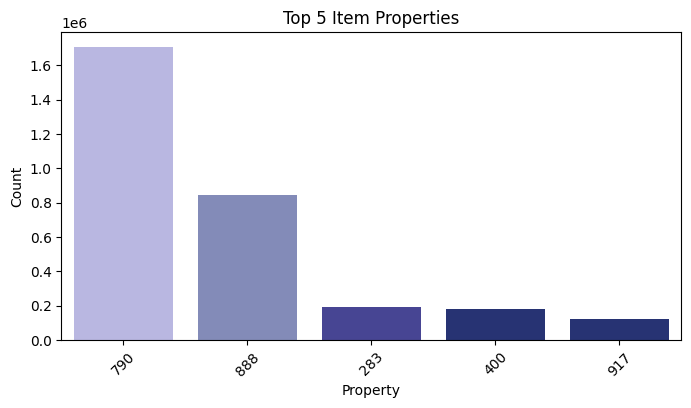

In [ ]:
custom_colors = ["#B2B0E8", "#7A85C1", "#3B38A0", "#1A2A80", "#1A2A80"]


plt.figure(figsize = (8, 4))
plt.xticks(rotation = 45)
sns.barplot(
    x = top_props.index,
    y = top_props.values,
    order = top_props.index,
    palette = custom_colors
)
plt.title("Top 5 Item Properties")
plt.xlabel("Property")
plt.ylabel("Count")
plt.show()

Q5
- Top three most interacted items in May and June.

In [49]:
events_cleaned["timestamp"] = pd.to_datetime(events_cleaned["timestamp"])

In [50]:
df_filtered = events_cleaned[
    (events_cleaned["timestamp"] >= "2015-06-01") &
    (events_cleaned["timestamp"] <= "2015-07-31")
]

In [51]:
df_filtered["Month"] = df_filtered["timestamp"].dt.strftime("%B")

C:\Users\Law\AppData\Local\Temp\ipykernel_18428\599921581.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [52]:
item_interaction_counts = df_filtered["itemid"].value_counts()

In [53]:
top_3_items = item_interaction_counts.head(2).index

In [54]:
top_items_df = df_filtered[df_filtered["itemid"].isin(top_3_items)]

In [55]:
grouped = top_items_df.groupby(["itemid", "Month"]).size().reset_index(name = "Count")

In [44]:
grouped = grouped.sort_values(["itemid", "Month"])

In [57]:
colors = {"June": "#282929", "July": "#757575"}

# Create Figure
fig = go.Figure()

for month in ["June", "July"]:
    month_data = grouped[grouped["Month"] == month]
    fig.add_trace(go.Bar(
        x = month_data["itemid"].astype(str) + " (" + month + ")",
        y = month_data["Count"],
        name = month,
        marker_color = colors[month],
        text = month_data["Count"],
        textposition = "inside",
        textfont = dict(color = "white" if month == "June" else "black")
    ))

fig.update_layout(
    barmode = "group",
    title = "Top 2 Items by Month (July & August)",
    xaxis_title = "Item ID (Month)",
    yaxis_title = "Interaction Count",
     yaxis = dict(
        showticklabels = False
    ),
    width = 700,
    height = 500
)

fig.show()

Q6
- least Interacted items

In [4]:
least_items = events_cleaned["itemid"].value_counts().tail(3).reset_index()
least_items.columns = ["itemid", "event"]

In [5]:
least_items["itemid_str"] = least_items["itemid"].astype(str)

In [8]:
color_list = ["#FEC5F6", "#DB8DD0", "#C562AF"]

color_map = {str(item): color for item, color in zip(least_items["itemid"], color_list)}

fig = px.bar(least_items, 
    x = "itemid_str", 
    y ="event",
    title = "Three Least Interacted Items",
    text = "event",
    color = "itemid_str",
    color_discrete_map = color_map
    
)

fig.update_layout(
    legend_title_text = "Item Id",
    xaxis_title = "Item Id",
    yaxis_title="Events",
        xaxis = dict(
        tickmode = "array",
        tickvals = least_items["itemid_str"],
        ticktext = least_items["itemid_str"]
    ),
    yaxis = dict(
        showticklabels = False
    ),
    width = 700,
    height = 500
)
fig.show()

Q7
- Total events types.

In [126]:
event_counts = events_cleaned["event"].value_counts().reset_index()
event_counts.columns = ["event", "count"]

In [127]:
event_counts["event"] = event_counts["event"].astype(str)

In [128]:
color_map = {
    "1": "#F564A9",
    "3": "#98A1BC",
    "5": "#DED3C4",
}

fig = px.pie(
    event_counts, 
    names = "event", 
    values = "count",
    title = "Distribution of Event Types",
    color = "event",
    color_discrete_map = color_map
)

fig.update_layout(
    legend_title_text = "event",
)
fig.show()

In [94]:
model.save("hybrid_model.h5")

c:\Users\Law\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

